# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [23]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:  The features that maximize variance might show up as the first PCA dimensions.  Let's calculate the variance of each feature.  

In [34]:
normalized_data = (data - data.mean()) / (data.max() - data.min())
var = normalized_data.var()
print var

Fresh               0.012718
Milk                0.010098
Grocery             0.010492
Frozen              0.006366
Detergents_Paper    0.013640
Delicatessen        0.003460
dtype: float64


After [normalizing](http://stackoverflow.com/a/12525836/7648) we can see that Detergents_Paper has the highest variance.  So Detergents_Paper will be the first principal component.  Let's now [compute the covariance of Detergents_Paper with the other features]((http://stackoverflow.com/a/32787030/7648)).

In [41]:
detergents_paper = 'Detergents_Paper'  
s = pd.Series({grocery_type: normalized_data[detergents_paper].cov(normalized_data[grocery_type]) 
               for grocery_type in normalized_data 
               if grocery_type != detergents_paper})
print s

Delicatessen    0.000476
Fresh          -0.001343
Frozen         -0.001226
Grocery         0.011061
Milk            0.007767
dtype: float64


Here we can see that Grocery has the most covariance with Detergents_Paper.  So Detergents_Paper and Grocery are probably the first two principal components.  I found the article ["Principal Component Analysis"](https://stat.ethz.ch/education/semesters/ss2012/ams/slides/v5.pdf) helpful in answering this. 

Linear combinations of the features will show up as ICA dimensions.  These new features will maximize independence.  Each vector in this data set will be some linear combination of Fresh, Milk, Grocery, Frozen,Detergents_Paper, and Delicatessen.

### PCA 

In [4]:
# Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=len(data.columns))
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

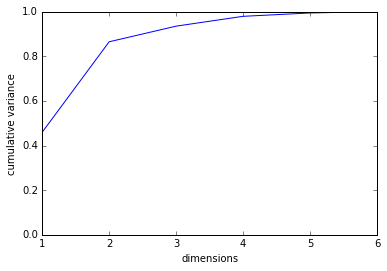

In [52]:
import matplotlib.pyplot as plt

x = np.arange(1, 7)
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), '-')
plt.xlabel('dimensions')
plt.ylabel('cumulative variance')
plt.ylim([0.0, 1.0])
plt.show()

Answer: We can see how the cumulative sum of the variance approaches 1.0 in the plot above.  If i were to use PCA on this dataset, I would choose 3 dimensions for my dimensions.  After 3 dimensions, the change in variance is less steep.

**3)** What do the dimensions seem to represent? How can you use this information?

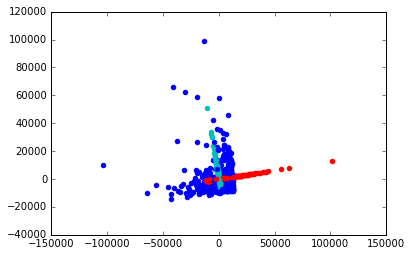

In [54]:
first_pc = pca.components_[0]
second_pc = pca.components_[1]

transformed_data = pca.transform(data)
plt.close()
for ii in transformed_data:
    plt.scatter(first_pc[0]*ii[0], first_pc[1]*ii[0], color="r")
    plt.scatter(second_pc[0]*ii[1], second_pc[1]*ii[1], color="c")
    plt.scatter(ii[0], ii[1], color="b")
    
plt.show()

Answer: The dimensions seem to represent the features.  We can use this information to find out which features are most useful in classifying data points.  Looking at the first two components (in red and cyan), we can see that they are orthogonal.  Let's look at the actual value of the first component:

In [55]:
print first_pc

[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]


From these values, we can see that the first entry has the largest absolute value, and, thus, that Fresh dominates the first component.  Let's look at the second component:

In [56]:
print second_pc

[-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]


Grocery and Milk (in that order) dominate the second component.  Hence, the distributor knows that the amount of Fresh, Grocery, and Milk that a store orders is what differentiates that store from other stores.  If two stores buy about the same amount of Fresh, then the distributor knows that the two stores will likely react the same to different changes in distribution policy.

### ICA

In [8]:
# Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
data_scaled = preprocessing.scale(data)

from sklearn.decomposition import FastICA
ica = FastICA()
ica.fit(data_scaled)

# Print the independent components
print ica.components_

[[ 0.00193392  0.07260048 -0.0550773  -0.00177143  0.01567576 -0.01707414]
 [-0.01093125 -0.00103289  0.00735043  0.05404891 -0.00265168 -0.01676763]
 [-0.00380912  0.01686284  0.11490758 -0.00708014 -0.13437409 -0.01615161]
 [ 0.05022515 -0.00631934 -0.00583923 -0.00328896  0.00972125 -0.00295345]
 [-0.0048809  -0.00161848 -0.00571174 -0.00253184  0.00243239  0.05096603]
 [ 0.00267466 -0.0139774   0.06025118  0.00204262 -0.00298658 -0.00399475]]


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: Each vector corresponds to a linear combination of features.  These components, or transformed features, identify fundamental features of your data that can be used for classification.  The primary feature affected by each of the first four vectors, respectively, is:

* Milk
* Frozen
* Detergents_Paper
* Fresh

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: K Means creates 'hard' boundaries between the clusters.  That is, each data point belongs to exactly one cluster.  On the other hand, Gaussian Mixture Models create 'soft' boundaries.  That is, each data point belongs to a given cluster with a certain probability.

* k-means clustering advantages 
    - [Cheap](http://stats.stackexchange.com/a/58857) relative to other unsupervised learning algorithms  
    - [Scales well](http://scikit-learn.org/stable/modules/clustering.html#k-means)
* [Gaussian mixture models advantages](http://scikit-learn.org/stable/modules/mixture.html#pros)
    - Fastest mixture model algorithm
    - No bias of the means towards zero
    
We will use k-means since it is fast.  Also, it makes sense to have hard boundaries defining the store clusters.  For the purposes of A/B testing, we have to consider a given store either a member or not a member of a sample.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [58]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [59]:
# First we reduce the data to two dimensions using PCA to capture variation
reduced_data = PCA(n_components=2).fit_transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [72]:
def create_clusters(reduced_data, n_clusters):
    # Implement your clustering algorithm here, and fit it to the reduced data for visualization

    kmeans = KMeans(n_clusters)
    kmeans.fit(reduced_data)
    
    return kmeans

# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

def obtain_labels(clusters, xx, yy):
    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
    
    return Z

def find_centroids(clusters):
    # Find the centroids for KMeans or the cluster means for GMM 
    centroids = clusters.cluster_centers_
    
    return centroids

def show_plot(reduced_data, centroids, xx, yy, Z):
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [86]:
def visualize_cluster_data(n_clusters):
    # The visualizer below assumes your clustering object is named 'clusters'
    clusters = create_clusters(reduced_data, n_clusters)
    print 'clusters:\n{}\n'.format(clusters)

    Z = obtain_labels(clusters, xx, yy)

    centroids = find_centroids(clusters)
    print 'centroids:\n{}\n'.format(centroids)

    show_plot(reduced_data, centroids, xx, yy, Z)

Answer: First let's try 8 clusters.

clusters:
KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

centroids:
[[  7855.70387893  -5357.47365718]
 [-31677.01702205  -6255.39517189]
 [  2787.06628956  24275.2601508 ]
 [-20964.64986166  68819.21772923]
 [-14389.27388383  -2507.41605083]
 [  7012.62228466   6928.39601904]
 [ -2900.14423445  -6032.43569237]
 [-74982.98228094  -1461.38586695]]



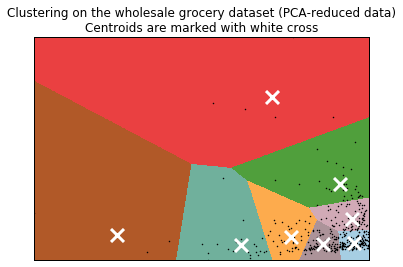

In [87]:
visualize_cluster_data(8)

Everything is pretty scrunched together in the lower right.  Let's try 4 clusters.

clusters:
KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

centroids:
[[-24220.71188261  -4364.45560022]
 [  3542.08605212  -4936.7212132 ]
 [  5710.98964991  12661.45687292]
 [-14537.71774395  61715.67085248]]



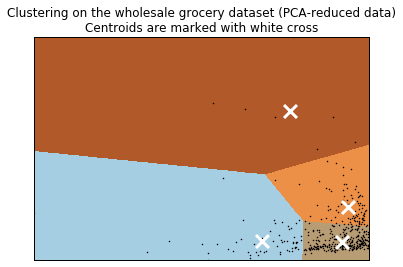

In [88]:
visualize_cluster_data(4)

That clustering looks better.  But it, and the previous plot make me wonder whether

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: The central objects in each cluster are the centroids.  You can think of them as an average customer within that cluster.

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: Plotting the output of the k-means algorithm gave me the most insight into the data.

**9)** How would you use that technique to help the company design new experiments?

Answer: When designing new experiments, I would use only a small sample of customers from each cluster in my experiment.  

**10)** How would you use that data to help you predict future customer needs?

Answer: I would use the experiment's result for the sample in each cluster to generalize and help predict future customer needs for all the customers in that cluster.